In [1]:
gene_familly = "AP2"

<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [2]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:31071] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/645922816/sm_segment.MacBook-Pro-de-Genereux.501.26800000.0 could be created.


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [4]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [5]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,5565,Bradi3g12566.1.p,METPLCYDEYSSSSSSSYYVYSDDDRVAYTDQTLVQYGLPQPPLSL...,295,0
1,5090,AT1G03790.1,MDVVCTEHQMRKPTVEIPPRKLLLSSKSFPSDSSSPRSPRKHNWNK...,393,0
2,2236,GSMUA_AchrUn_randomP23040_001,MNMNASDNWLDFSLSQQRCLLEAFSDAPHHHGLSLSLSLSTNAATE...,469,1
3,8018,LPERR05G21720.1,MESMVGVKRKNVVVGGGDGREMLPPSPAPAPVVEFPIGYQSSSPTP...,634,0
4,1489,KHN36319.1,MNIGVPSHLHQTQPSSAAVEAVPPNFYHHTPLHNYGLYYELEGEHV...,548,1


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7115 entries, 0 to 7114
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7115 non-null   int64 
 1   id          7115 non-null   object
 2   sequence    7115 non-null   object
 3   length      7115 non-null   int64 
 4   class       7115 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 278.1+ KB


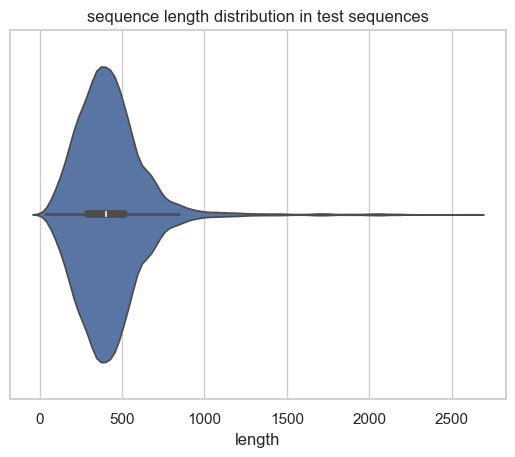

In [7]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
21**2

441

In [48]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

100

In [49]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AA,AC,AH,AI,AK,AR,AY,CE,CK,CL,...,WG,WK,WQ,WR,WT,YD,YE,YL,YR,YW
0,0.013216,0.00000,0.000000,0.002203,0.004405,0.006608,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.002203,0.0,0.000000,0.000000,0.000000,0.004405,0.000000,0.0
1,0.002433,0.00365,0.003650,0.002433,0.003650,0.003650,0.000000,0.0,0.002433,0.001217,...,0.001217,0.000000,0.000000,0.0,0.001217,0.001217,0.000000,0.004866,0.000000,0.0
2,0.003521,0.00000,0.000000,0.003521,0.003521,0.003521,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.003521,0.003521,0.000000,0.000000,0.0
3,0.004566,0.00000,0.004566,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.004566,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.004566,0.004566,0.0
4,0.008798,0.00000,0.000000,0.002933,0.000000,0.005865,0.002933,0.0,0.000000,0.002933,...,0.000000,0.002933,0.000000,0.0,0.000000,0.005865,0.000000,0.002933,0.000000,0.0


In [50]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 100)
X_test: (1779, 100)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [51]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,121 (270.00 KB)

 Trainable params: 69,121 (270.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8377 - loss: 0.5712 - val_accuracy: 0.9480 - val_loss: 0.1509
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.1306 - val_accuracy: 0.9494 - val_loss: 0.1285
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1099 - val_accuracy: 0.9522 - val_loss: 0.1165
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1109 - val_accuracy: 0.9438 - val_loss: 0.1427
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1051 - val_accuracy: 0.9515 - val_loss: 0.1224
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9665 - loss: 0.0968 - val_accuracy: 0.9571 - val_loss: 0.1064
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.0888 - val_accuracy: 0.9508 - val_loss: 0.1246
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9702 - loss: 0.0762 - val_accuracy: 0.9606 - v

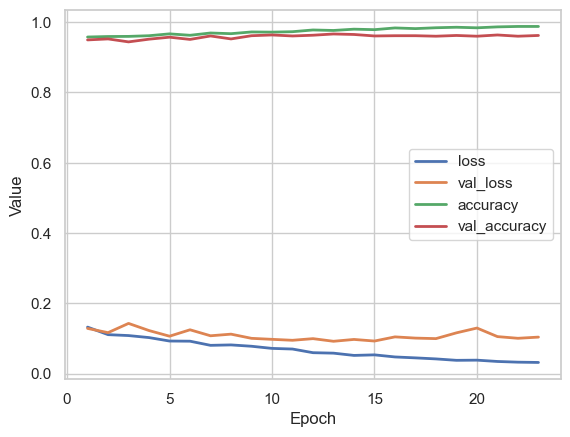

In [52]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [53]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [54]:
21**3

9261

In [73]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [74]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AYD,YLG,RGV,EAH,FRG,KYW,GRW,TGR,SGF,YWG,...,TGA,HPV,EDY,CNI,SGG,GNL,SYD,GVH,AYA,TLS
0,0.0,0.002208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.003534,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.002941,0.0,0.0,0.0,0.0


In [75]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 2000)
X_test: (1779, 2000)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [76]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │       512,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 555,521 (2.12 MB)

 Trainable params: 555,521 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8519 - loss: 0.5352 - val_accuracy: 0.9775 - val_loss: 0.0665
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9760 - loss: 0.0653 - val_accuracy: 0.9803 - val_loss: 0.0555
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9889 - loss: 0.0389 - val_accuracy: 0.9789 - val_loss: 0.0611
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.0252 - val_accuracy: 0.9768 - val_loss: 0.0830
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9920 - loss: 0.0220 - val_accuracy: 0.9761 - val_loss: 0.0804
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0079 - val_accuracy: 0.9831 - val_loss: 0.0629
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9796 - val_loss: 0.0798
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9803 - v

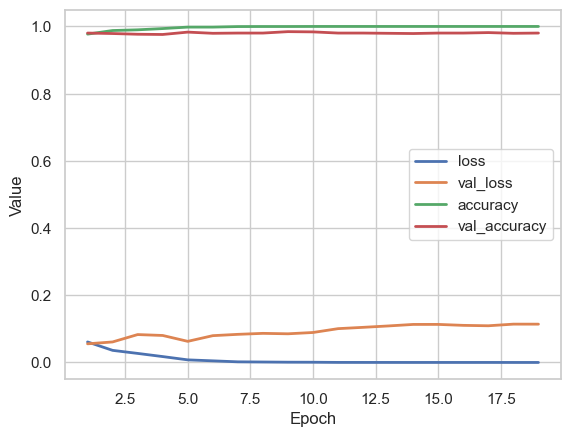

In [77]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [78]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [10]:
21**4

194481

In [11]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [12]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAH,AAAR,AAAS,AAEA,AAHA,AAIE,AAIK,AAIR,AAKR,AALK,...,YRRT,YSTQ,YVAH,YVYL,YWGA,YWGP,YWGQ,YWGT,YWKA,YYRC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [14]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8618 - loss: 0.5568 - val_accuracy: 0.9536 - val_loss: 0.1155
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9630 - loss: 0.1175 - val_accuracy: 0.9543 - val_loss: 0.1044
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9607 - loss: 0.1133 - val_accuracy: 0.9543 - val_loss: 0.1034
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.1039 - val_accuracy: 0.9564 - val_loss: 0.1023
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.0815 - val_accuracy: 0.9578 - val_loss: 0.0876
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.0775 - val_accuracy: 0.9663 - val_loss: 0.0855
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0690 - val_accuracy: 0.9606 - val_loss: 0.0851
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.0563 - val_accuracy: 0.9684 - v

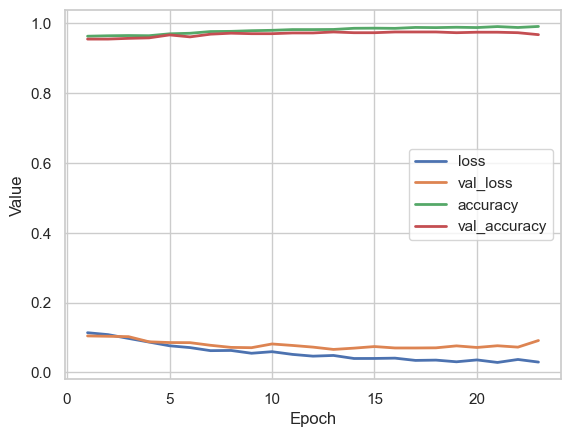

In [15]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [16]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [17]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [10]:
21**5

4084101

In [41]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

ValueError: Unsupported method. Supported methods: 'f_test', 'rf', 'chi2', 'variance-threshold', 'lasso'.

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,QQQQQ,XXXXX
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,521 (295.00 KB)

 Trainable params: 75,521 (295.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5111 - loss: 0.6933 - val_accuracy: 0.5018 - val_loss: 0.6932
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5008 - loss: 0.6935 - val_accuracy: 0.5018 - val_loss: 0.6933
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4956 - loss: 0.6933 - val_accuracy: 0.5018 - val_loss: 0.6934
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5048 - loss: 0.6932 - val_accuracy: 0.5018 - val_loss: 0.6936
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5018 - val_loss: 0.6935
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5059 - loss: 0.6930 - val_accuracy: 0.4968 - val_loss: 0.6939
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4875 - loss: 0.6932 - val_accuracy: 0.4961 - val_loss: 0.6947
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5049 - loss: 0.6931 - val_accuracy: 0.4954 - v

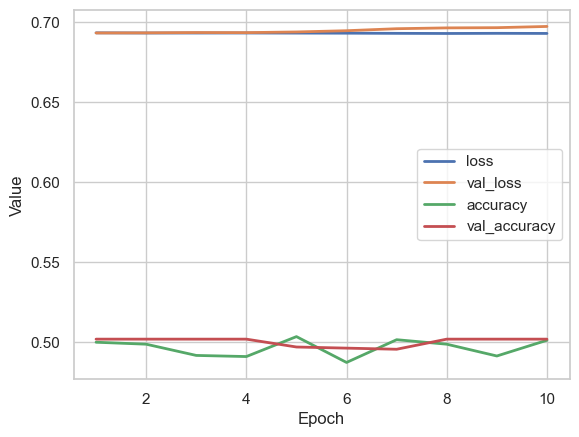

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


In [17]:
# END

In [18]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################